/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.1064
Epoch 2/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0191
Epoch 3/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0167
Epoch 4/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0121
Epoch 5/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0092
Epoch 6/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0093
Epoch 7/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0114
Epoch 8/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0147
Epoch 9/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0123
Epoch 10/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0097
Epoch 11/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0195
Epoch 12/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0112
Epoch 13/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0115
Epoch 14/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0081
Epoch 15/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0080
Epoc

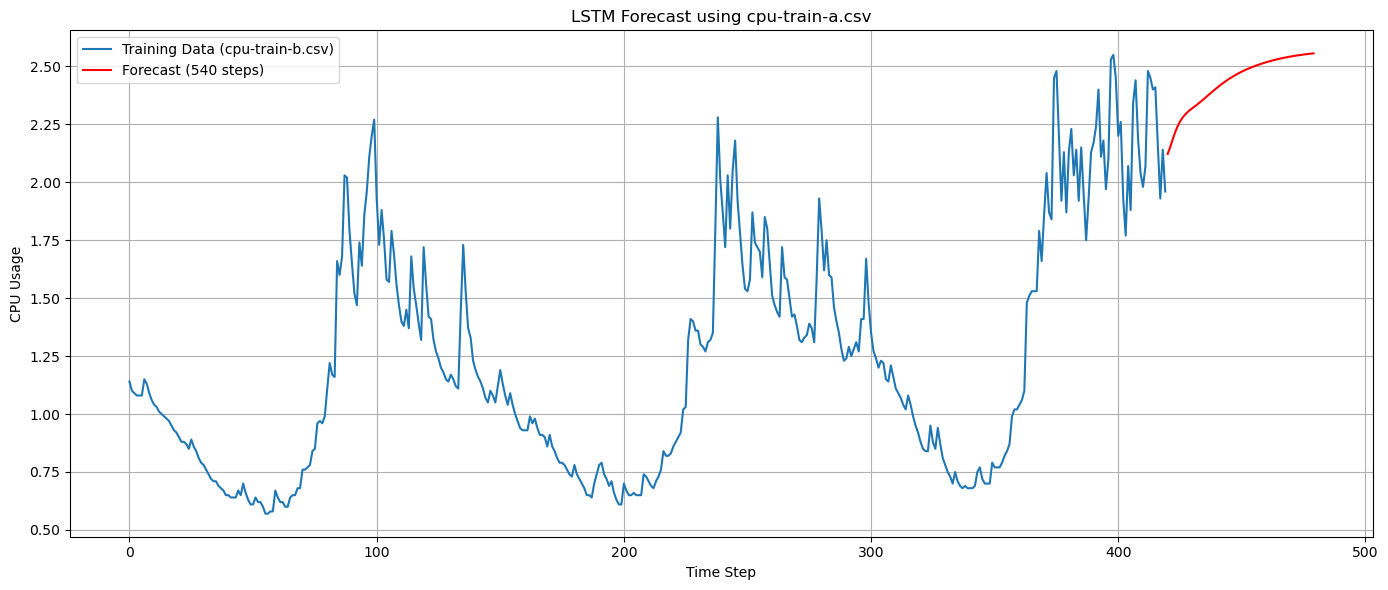

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# 1. Last inn datasettet
df = pd.read_csv("/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU_DATA FRA KAGGLE/Test/ww/datasets/gauravduttakiit/cpu-utilization/cpu-train-a.csv")  
data = df['cpu'].values.reshape(-1, 1)

# 2. Skaler data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 3. Lag sliding window
window_size = 35
X, y = [], []
for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i + window_size])
    y.append(scaled_data[i + window_size])
X, y = np.array(X), np.array(y)

# 4. Bygg LSTM-modell
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 5. Tren modellen
model.fit(X, y, epochs=70, batch_size=32, verbose=1)

# 6. Prediker x steg frem i tid
forecast_steps = 60
input_seq = scaled_data[-window_size:].reshape(1, window_size, 1)
forecast = []

for _ in range(forecast_steps):
    pred = model.predict(input_seq, verbose=0)[0, 0]
    forecast.append(pred)
    input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

# 7. Gjør forecast tilbake til original skala
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

# 8. Plot resultatet
plt.figure(figsize=(14, 6))
plt.plot(data, label="Training Data (cpu-train-b.csv)")
plt.plot(range(len(data), len(data) + forecast_steps), forecast, label="Forecast (540 steps)", color='red')
plt.xlabel("Time Step")
plt.ylabel("CPU Usage")
plt.title("LSTM Forecast using cpu-train-a.csv")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

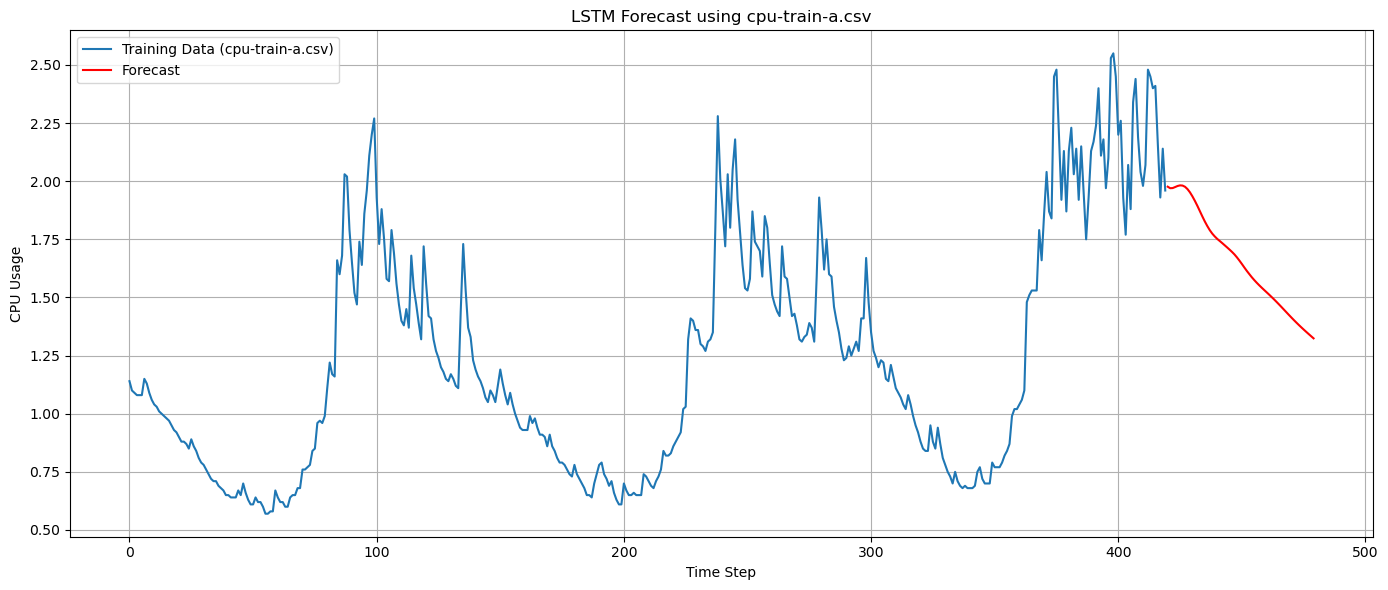

In [86]:
# 8. Plot resultatet
plt.figure(figsize=(14, 6))
plt.plot(data, label="Training Data (cpu-train-a.csv)")
plt.plot(range(len(data), len(data) + forecast_steps), forecast, label="Forecast", color='red')
plt.xlabel("Time Step")
plt.ylabel("CPU Usage")
plt.title("LSTM Forecast using cpu-train-a.csv")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("lstm_forecast_vs_true_aLSTM.png")  # Save as image
plt.show()

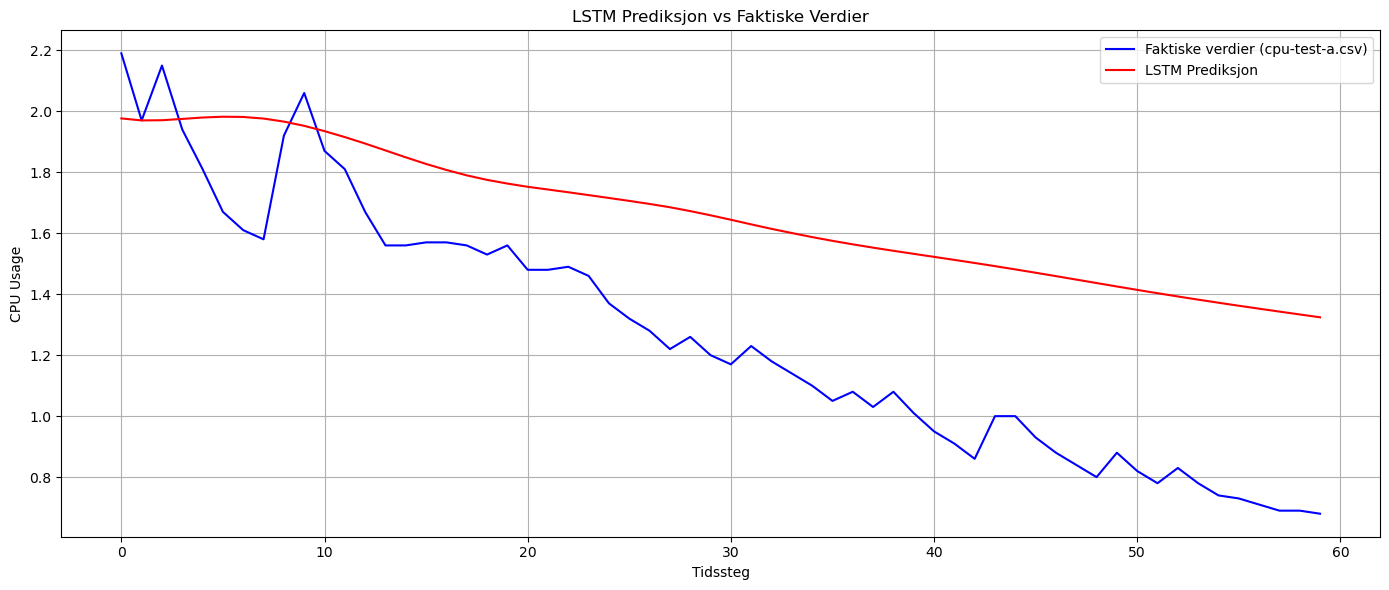

In [50]:
# 9. Last inn testsett
test_df = pd.read_csv("/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU_DATA FRA KAGGLE/Test/ww/datasets/gauravduttakiit/cpu-utilization/cpu-test-a.csv")
true_values = test_df['cpu'].values[:forecast_steps]  # match antall steg

# 10. Plott sammenligning
plt.figure(figsize=(14, 6))
plt.plot(true_values, label="Faktiske verdier (cpu-test-a.csv)", color='blue')
plt.plot(forecast, label="LSTM Prediksjon", color='red')
plt.title("LSTM Prediksjon vs Faktiske Verdier")
plt.xlabel("Tidssteg")
plt.ylabel("CPU Usage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# 9. Last inn testsett og hent ekte verdier
test_df = pd.read_csv("/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU_DATA FRA KAGGLE/Test/ww/datasets/gauravduttakiit/cpu-utilization/cpu-test-a.csv")
true_values = test_df['cpu'].values[:forecast_steps]

# 10. Beregn feilmål
mse = mean_squared_error(true_values, forecast)
mae = mean_absolute_error(true_values, forecast)

# MAPE (håndterer nullverdier)
non_zero_indices = true_values != 0
mape = np.mean(np.abs((true_values[non_zero_indices] - forecast[non_zero_indices]) / true_values[non_zero_indices])) * 100

# 11. Skriv ut resultatene
print(f" Mean Squared Error (MSE): {mse:.4f}")
print(f" Mean Absolute Error (MAE): {mae:.4f}")
print(f" Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


NameError: name 'forecast_steps' is not defined

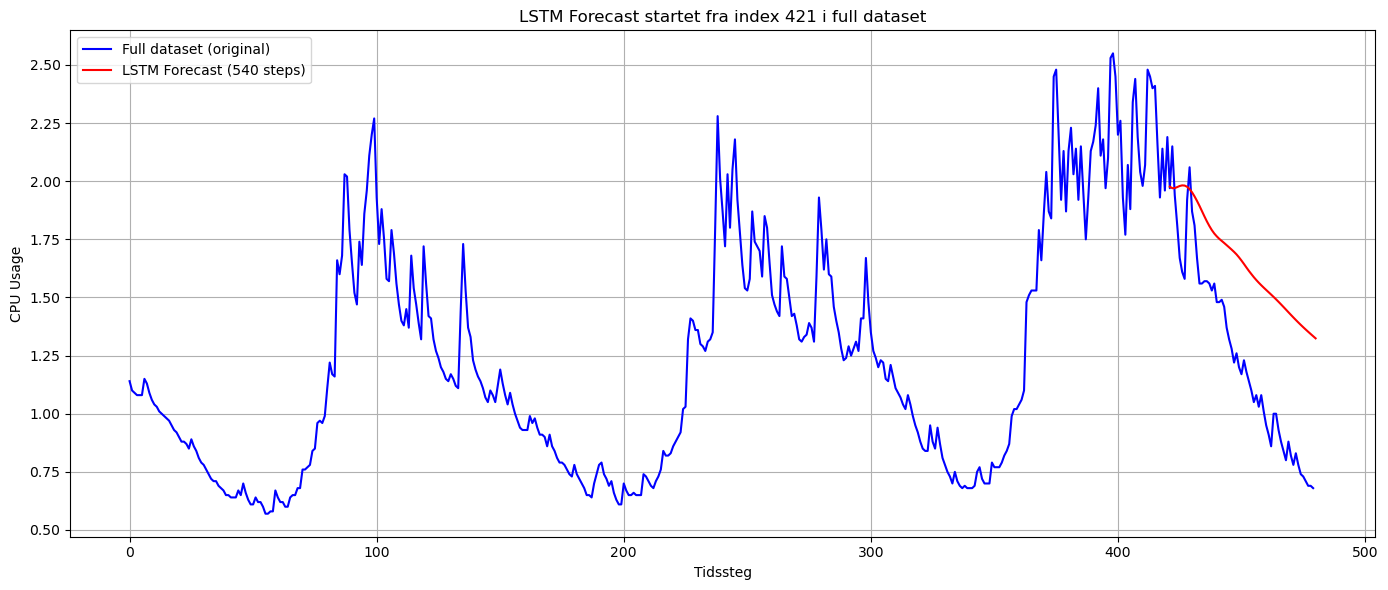

In [41]:
#treningsett B full med predikasjon over:
# 1. Last inn full-datasettet
full_df = pd.read_csv("/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU_DATA FRA KAGGLE/Test/ww/datasets/gauravduttakiit/cpu-utilization/cpu-full-a.csv")
full_data = full_df['cpu'].values

# 2. Angi hvor prediksjonen skal begynne visuelt (x-aksen)
forecast_start_index = 421  # <-- juster her etter behov

# 3. Plot
plt.figure(figsize=(14, 6))
plt.plot(full_data, label='Full dataset (original)', color='blue')
plt.plot(range(forecast_start_index, forecast_start_index + forecast_steps), forecast, label='LSTM Forecast (540 steps)', color='red')
plt.xlabel("Tidssteg")
plt.ylabel("CPU Usage")
plt.title("LSTM Forecast startet fra index 421 i full dataset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


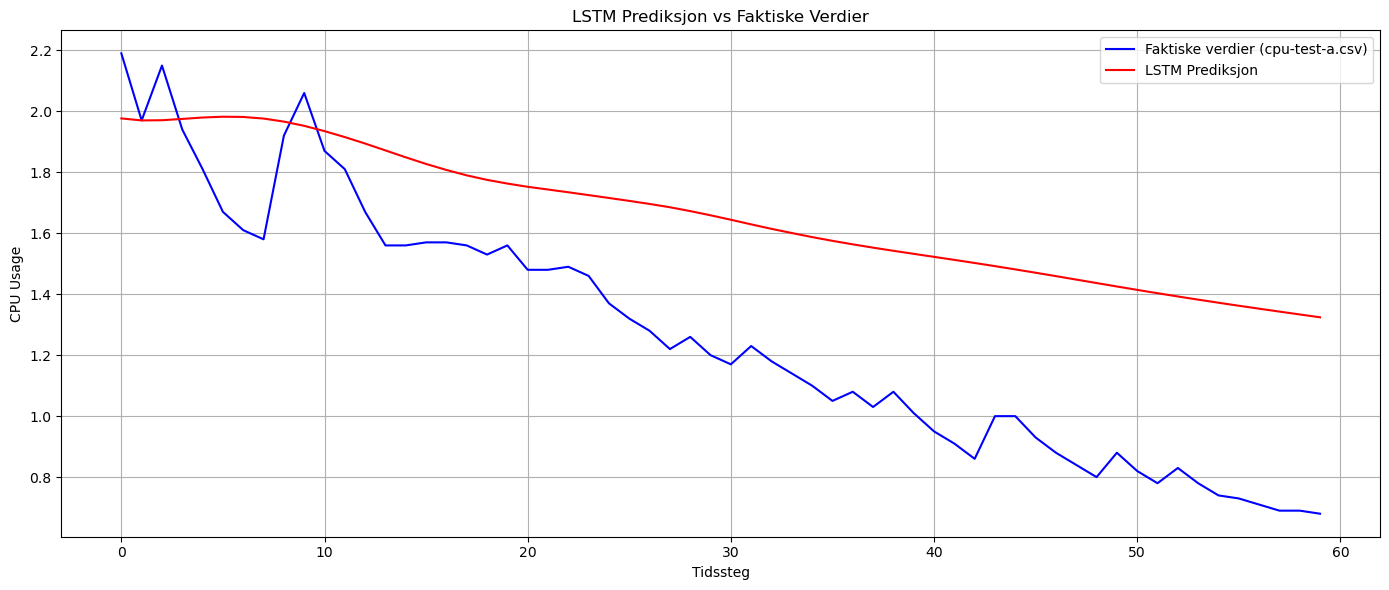

In [67]:
#Lagringer
# === Save forecast comparison plot ===
plt.figure(figsize=(14, 6))
plt.plot(true_values, label="Faktiske verdier (cpu-test-a.csv)", color='blue')
plt.plot(forecast, label="LSTM Prediksjon", color='red')
plt.title("LSTM Prediksjon vs Faktiske Verdier")
plt.xlabel("Tidssteg")
plt.ylabel("CPU Usage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("lstm_forecast_vs_true_aLSTM.png")  # Save as image
plt.show()


In [69]:
#LAgre MSE og MAe i en txt fil
with open("forecast_metrics_aLSTM.txt", "w") as f:
    f.write(f"Mean Squared Error (MSE): {mse:.4f}\n")
    f.write(f"Mean Absolute Error (MAE): {mae:.4f}\n")



In [71]:
# Lag nytt datasett med forecast på slutten
full_with_forecast = np.concatenate([full_data[:forecast_start_index], forecast])



In [73]:
# Lag og lagre som DataFrame
full_forecast_df = pd.DataFrame(full_with_forecast, columns=["CPU"])
full_forecast_df.to_csv("full_dataset_with_forecast_aLSTM.csv", index=False)
